## ML3 - Machine Learning in Practice; Generalization

#### Goals
* Get familiar with tuning hyperparameters and tweaking models
* Go through the exercise of finding the "sweet spot" between underfitting and overfitting

In [136]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda') # nvidia/cuda
elif torch.mps.is_available():
    device = torch.device('mps') # apple
else:
    'cpu' # no acceleration

print(f'Using device: {device}')

Using device: mps


## Load CIFAR-10 and Display Sample Images

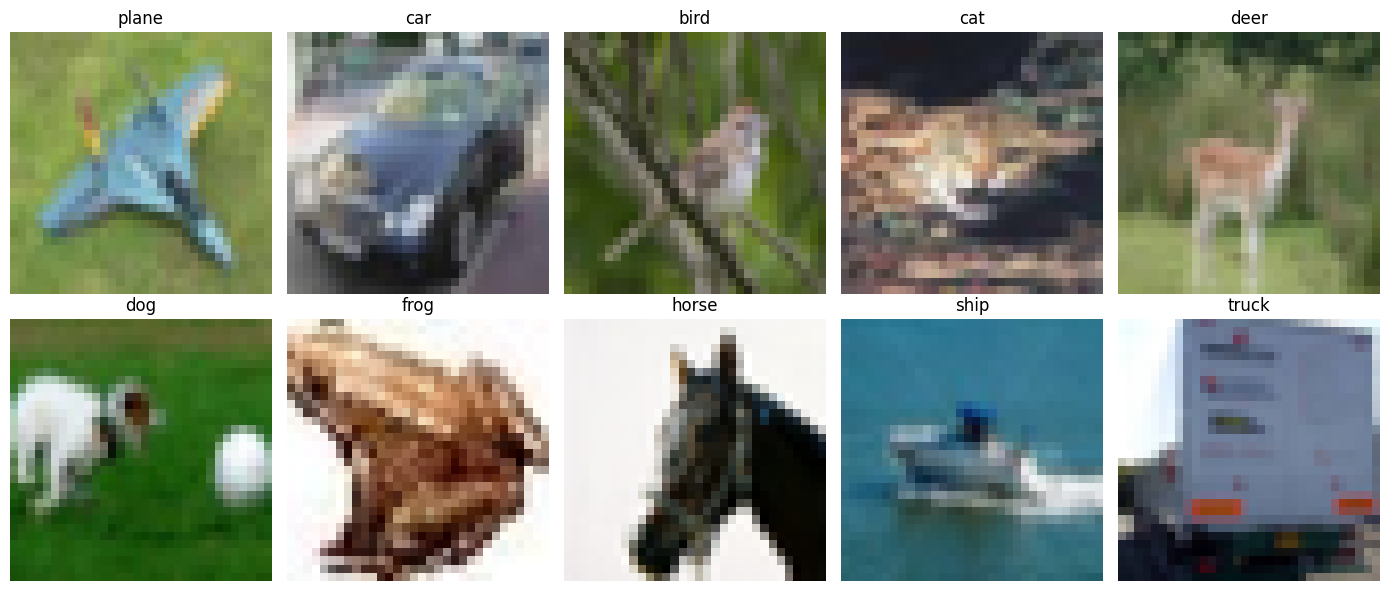

In [137]:
# Define CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# normalize the data to have 0.5 mean and 0.5 standard deviation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Load CIFAR-10 train
cifar10_train = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

# Load CIFAR-10 test data
cifar10_test = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

# Use a small subset for faster training
subset_size = 2000 
indices = torch.randperm(len(full_dataset))[:subset_size]
train_subset = torch.utils.data.Subset(cifar10_train, indices)

# Use a small test set so validation is quick
subset_size = 256  
indices = torch.randperm(len(cifar10_test))[:subset_size]
test_subset = torch.utils.data.Subset(cifar10_test, indices)


# Display one image from each class
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
axes = axes.flatten()

# Create a dictionary to track which classes we've seen
class_indices = {i: None for i in range(len(classes))}

# Find one image from each class
for idx, (image, label) in enumerate(train_subset):
    if class_indices[label] is None:
        class_indices[label] = idx
    if all(v is not None for v in class_indices.values()):
        break

# Plot one image from each class
for class_idx in range(len(classes)):
    image, label = train_subset[class_indices[class_idx]]
    # Denormalize for display: multiply by std and add mean
    image = image * 0.5 + 0.5  # undo normalization
    image = image.permute(1, 2, 0).numpy()  # Convert to HWC format
    axes[class_idx].imshow(image)
    axes[class_idx].set_title(f'{classes[label]}')
    axes[class_idx].axis('off')

plt.tight_layout()
plt.show()


## Part 2: Linear Classifier (Single-layer Neural Network)

### Model definition

In [138]:
# Define a multi-layer perceptron
class MLPClassifier(nn.Module):
    def __init__(self, input_size=3*32*32, hidden_sizes=[512, 256], num_classes=10, dropout_prob=0.2):
        super(MLPClassifier, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Hidden layers with ReLU activation
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(prev_size, num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)
        # Pass through network
        x = self.network(x)
        return x



### Evaluation Routine

In [139]:
def evaluate_model(model, dataset, batch_size=128):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            num_correct += (predicted == labels).sum().item()
            num_samples += labels.size(0)
            
    accuracy = num_correct / num_samples
    return accuracy

### Training Loop


In [140]:
def train_model(model, train_dataset, test_dataset, num_epochs=10, batch_size=128, learning_rate=0.01):

    # takes care of loading data and creating batches for us
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 

    # calculates softmax + cross-entropy loss for us:
    loss_fn = nn.CrossEntropyLoss()

    # takes care of the gradient updates for us:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # we'll track some history:
    train_losses = []
    train_accuracy = []
    test_accuracy = []

    for epoch in range(num_epochs):
        model.train() # set model to "Train" mode
        total_loss = 0.0
        num_batches = 0
        num_correct = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images) # compute the model outputs
            loss = loss_fn(outputs, labels) # calculate the loss
            
            # Backward pass and optimization
            optimizer.zero_grad()   # Clear old gradients
            loss.backward()         # Compute gradients
            optimizer.step()        # Update parameters
            
            total_loss += loss.item()
            num_batches += 1

            # calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            num_correct += (predicted == labels).sum().item()
        
        avg_loss = total_loss / num_batches
        train_losses.append(avg_loss)
        
        test_acc = evaluate_model(model, test_dataset)
        test_accuracy.append(test_acc)

        train_acc = num_correct / len(train_dataset)
        train_accuracy.append(train_acc)
        if epoch % 5 == 0:
            print(f'Epoch {epoch+1:2d}: Loss = {avg_loss:.4f}, Train Accuracy = {train_acc:.4f}, Test accuracy = {test_acc:.4f}')

    return train_losses, train_accuracy, test_accuracy

### Create and train the model

In [141]:
## Hyperparameters - tune these to try to get a good model that doesn't overfit!
hidden_sizes = [512, 256]
num_epochs = 50
batch_size = 128
learning_rate = 0.1

# Create MLP model and move to device
mlp_model = MLPClassifier(input_size=3*32*32, hidden_sizes=hidden_sizes, num_classes=10).to(device)
print(f'MLP model created:')
print(mlp_model)
print(f'Number of parameters: {sum(p.numel() for p in mlp_model.parameters()):,}')
print('Training MLP Classifier...')
print('='*50)

# Train the MLP classifier
mlp_train_losses, mlp_train_accs, mlp_test_accs = train_model(
    mlp_model, data_subset, test_subset,
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    learning_rate=learning_rate
)

print('='*50)
print(f'MLP Classifier - Final Train Accuracy: {mlp_train_accs[-1]:.2f}%')

MLP model created:
MLPClassifier(
  (network): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=10, bias=True)
  )
)
Number of parameters: 1,707,274
Training MLP Classifier...
Epoch  1: Loss = 2.2622, Train Accuracy = 0.1610, Test accuracy = 0.2930
Epoch  6: Loss = 1.7914, Train Accuracy = 0.3760, Test accuracy = 0.4258
Epoch 11: Loss = 1.4909, Train Accuracy = 0.4830, Test accuracy = 0.4219
Epoch 16: Loss = 1.2301, Train Accuracy = 0.5790, Test accuracy = 0.4336
Epoch 21: Loss = 1.0044, Train Accuracy = 0.6605, Test accuracy = 0.4336
Epoch 26: Loss = 0.7732, Train Accuracy = 0.7560, Test accuracy = 0.4648
Epoch 31: Loss = 0.6112, Train Accuracy = 0.8105, Test accuracy = 0.4531
Epoch 36: Loss = 0.4851, Train Accuracy = 0.8580, Test accuracy = 0.3

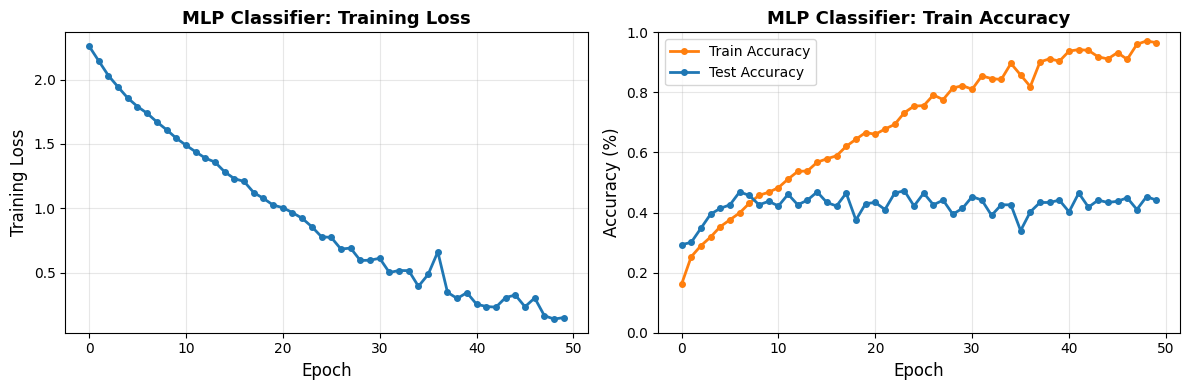

In [142]:
# Visualize MLP classifier training
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Training loss
ax = axes[0]
ax.plot(mlp_train_losses, marker='o', linewidth=2, markersize=4)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)
ax.set_title('MLP Classifier: Training Loss', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 2: Train and test accuracy
ax = axes[1]
ax.plot(mlp_train_accs, marker='o', linewidth=2, markersize=4, color='tab:orange', label="Train Accuracy")
ax.plot(mlp_test_accs, marker='o', linewidth=2, markersize=4, color='tab:blue', label="Test Accuracy")
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('MLP Classifier: Train Accuracy', fontsize=13, fontweight='bold')
ax.legend()


ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('mlp_classifier_training.png', dpi=100, bbox_inches='tight')
plt.show()